In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2023-01-21 12:38:59.779661: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64
    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

#     OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
#     OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
#     OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

#     OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)
    
    return model


In [6]:
def create_model_head():
    
    IN_vec = keras.Input((128,))    
    X = IN_vec
    #
    X = keras.layers.Dense(1024, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)

    X = keras.layers.Dropout(0.4)(X)
    
    #
    X = keras.layers.Dense(512, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    X = keras.layers.Dropout(0.4)(X)
    
    X = keras.layers.Dense(128, activity_regularizer=keras.regularizers.L2(1e-2))(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation("gelu")(X)
    #X = keras.layers.Activation("relu")(X)
    
    OUT = X
    OUT = keras.layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(-10))(OUT)

    model = keras.models.Model(inputs=IN_vec, outputs=OUT)
    
    return model

In [7]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [8]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [9]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*pos*.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*pos*.npy"))

print('neg:{} vs pos:{}'.format(len(filename_neg_train), len(filename_pos_train)))

neg:6739773 vs pos:27551


In [10]:
len(filename_neg_valid[::200] + filename_pos_valid[::20])

16097

In [11]:
#filename_valid = filename_neg_valid[::600] + filename_pos_valid[::5]
#filename_valid = filename_neg_valid[::200] + filename_pos_valid[::50]

filename_valid = filename_neg_valid[::200] + filename_pos_valid[::20]
print(len(filename_valid))

L_valid = len(filename_valid)

VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

16097


In [12]:
model_head = create_model_head()
# W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/STN_Lead4/')
# model_head.set_weights(W_old)

for layer in model_head.layers: 
    layer.trainable = False

2023-01-21 12:46:00.856229: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-21 12:46:00.857880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-21 12:46:00.910048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-01-21 12:46:00.910084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-21 12:46:00.971812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-21 12:46:00.971893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [13]:
model = create_model(input_shape=(64, 64, 15))

W_new = model.get_weights()
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/{}/'.format('RE0_15p_base'))

for i in range(len(W_new)):
    if W_new[i].shape == W_old[i].shape:
        W_new[i] = W_old[i]
    else:
        ewraewthws
        
model.set_weights(W_new)

# for layer in model_head.layers: 
#     layer.trainable = False

In [14]:
IN = layers.Input(shape=(64, 64, 15))

VEC = model(IN)
OUT = model_head(VEC)

model_final = Model(inputs=IN, outputs=OUT)

In [15]:
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_base_tune/')
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

In [16]:
Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2023-01-15 13:11:57.673982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-15 13:11:57.682589: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-01-15 13:11:58.877503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-01-15 13:12:02.902161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


0.034065330086322745


In [17]:
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_base/')
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

0.031870989268310626


In [16]:
W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE1_15p_full/')
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-4))
model_final.set_weights(W_old)

Y_pred = model_final.predict([VALID_input_64])
record_temp = verif_metric(VALID_target, Y_pred)

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2023-01-21 12:47:08.913353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-21 12:47:09.023647: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2023-01-21 12:47:10.263545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-01-21 12:47:14.211757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


0.03020596704790702


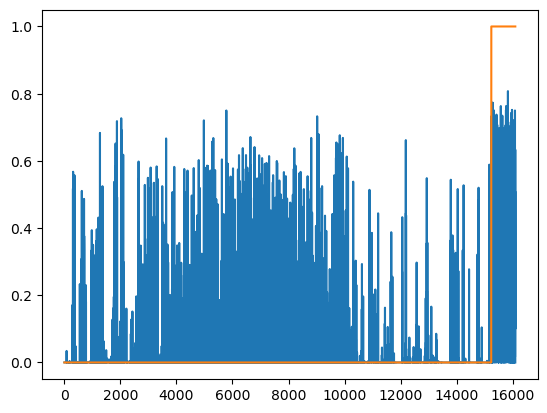

In [17]:
plt.plot(Y_pred)
plt.plot(VALID_target)

In [ ]:
seeds = 3725#1567

min_del = 0
max_tol = 1000 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE1_15p_full'
model_name = '{}'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = record_temp #0.01840167896363949 #record_temp
print("Initial record: {}".format(record))

set_seeds(seeds)
    
for i in range(epochs):
    start_time = time.time()

    # loop of batch
    for j in range(L_train):

        N_pos = 20
        N_neg = batch_size - N_pos

        ind_neg = du.shuffle_ind(L_neg)
        ind_pos = du.shuffle_ind(L_pos)

        file_pick_neg = []
        for ind_temp in ind_neg[:N_neg]:
            file_pick_neg.append(filename_neg_train[ind_temp])

        file_pick_pos = []
        for ind_temp in ind_pos[:N_pos]:
            file_pick_pos.append(filename_pos_train[ind_temp])

        file_pick = file_pick_neg + file_pick_pos

        if len(file_pick) != batch_size:
            sregwet

        for k in range(batch_size):
            data = np.load(file_pick[k])

            for l, c in enumerate(ind_pick_from_batch):
                temp = data[..., c] 
                X_batch_64[k, ..., l] = temp

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer

        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]

        # train on batch
        model_final.train_on_batch(X_batch_64, Y_batch);

    # epoch end operations
    Y_pred = model_final.predict([VALID_input_64])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1

    record_temp = verif_metric(VALID_target, Y_pred)

    # if i % 10 == 0:
    #     model.save(model_path_backup)

    if (record - record_temp > min_del) and np.max(Y_pred)>0.5:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model_final.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        if record_temp >= 2.0:
            print('Early stopping')
            break;
        else:
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.03071174749219138
0.03380413304665752
Validation loss 0.03380413304665752 NOT improved
0.030702383803916815
Validation loss improved from 0.03071174749219138 to 0.030702383803916815
save to: /glade/work/ksha/NCAR/Keras_models/RE1_15p_full


2023-01-15 14:09:27.597553: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE1_15p_full/assets
--- 528.5307521820068 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.033148081993337276
Validation loss 0.033148081993337276 NOT improved
0.0337361294059541
Validation loss 0.0337361294059541 NOT improved
0.03150154820619115
Validation loss 0.03150154820619115 NOT improved
0.0347453745047342
Validation loss 0.0347453745047342 NOT improved
0.031827676331640894
Validation loss 0.031827676331640894 NOT improved
0.03261382409767154
Validation loss 0.03261382409767154 NOT improved
0.03329192878003882
Validation loss 0.03329192878003882 NOT improved
0.03327353682487822
Validation loss 0.03327353682487822 NOT improved
0.03370997551823045
Validation loss 0.03370997551823045 NOT improved
0.03274941324512914
Validation loss 0.03274941324512914 NOT improved
0.03588887572453471
Validation loss 0.03588887572453471 NOT improved
0.032449076289815734
Validation loss 0.032449076289815734 NOT improved


In [ ]:
plt.plot(Y_pred)